<a href="https://colab.research.google.com/github/Rohan-Dawar/meanCenters/blob/main/meanCenterSports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MEAN CENTERS OF NORTH AMERICAN MAJOR LEAGUE SPORTS

#### This script produces images of the mean centers of the major league sports in North America:

*   NBA
*   NHL
*   NBA
*   MLB
*   MLS



In [ ]:
#Dependencies
import pandas as pd
!pip install geopandas
!pip install descartes
import geopandas as gpd
import descartes
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [ ]:
# Major League Coordinates Dataframe
mlb = pd.read_json('https://gist.githubusercontent.com/the55/2155142/raw/30a251395cd3c04771f29f2a6295fc8849b73d11/mlb_stadium.json')
nhl = pd.read_json('https://raw.githubusercontent.com/NHLScoreBot/arenas/master/teams.json', orient='index')
nfl = pd.read_csv('https://raw.githubusercontent.com/Sinbad311/CloudProject/master/NFL%20Stadium%20Latitude%20and%20Longtitude.csv')
nba = pd.read_csv('https://raw.githubusercontent.com/matiullah23/nba-attendance/master/Data/Age%20of%20Arena.csv', encoding='latin-1')
mls = pd.read_csv('https://raw.githubusercontent.com/gavinr/usa-soccer/master/mls.csv')

In [ ]:
# Clean Coordinates from NBA df
def clean(coord):
  c = str(coord)
  c = c.replace('N','')
  c = c.replace('W','')
  c = c.replace('¡','')
  c = c.split(' ')
  lat, lon = float(c[0]), float(c[1])*-1
  return lat, lon

nba['Coordinates'] = nba['Coordinates'].dropna().apply(clean)
nba = nba.dropna()
nba[['latitude', 'longitude']] = pd.DataFrame(nba['Coordinates'].tolist(), index=nba.index)

In [ ]:
# Load Shapefiles
shp = gpd.read_file('/content/cb_2018_us_state_5m.shp')

In [ ]:
# Dict of Major Leagues and their coordinate columns, logo pngs, colors
majors = {
    'NFL' : (nfl, 'latitude', 'longitude', 'nfl.png', 'blue'),
    'NBA' : (nba, 'latitude', 'longitude', 'nba.png', 'red'),
    'NHL' : (nhl, 'lat', 'long', 'nhl.png', 'violet'),
    'MLB' : (mlb, 'lat', 'lng', 'mlb.png', 'orange'),
    'MLS' : (mls, 'latitude', 'longitude', 'mls.png', 'green')}

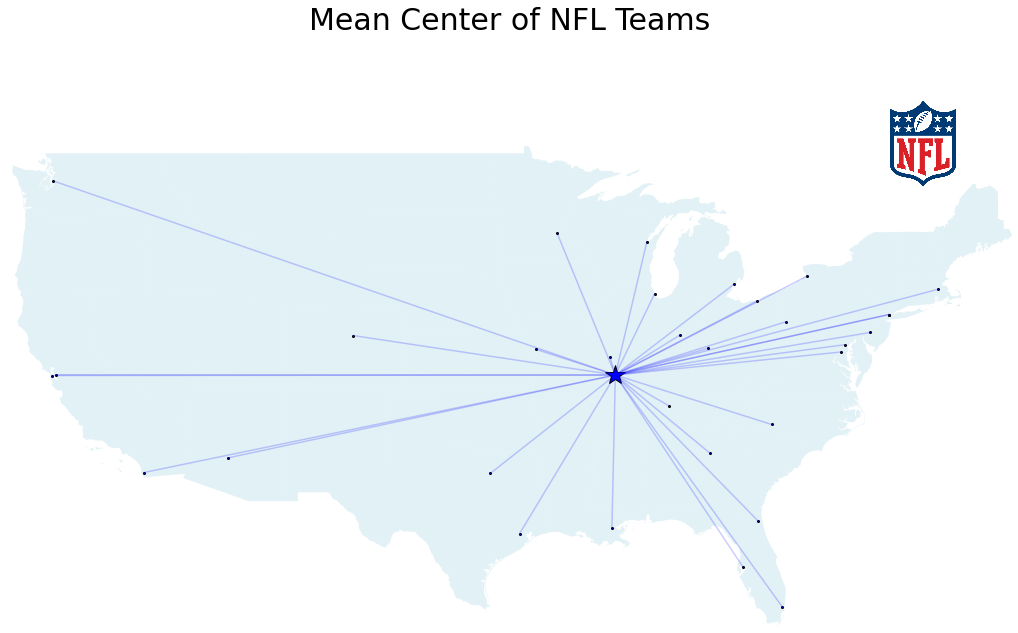

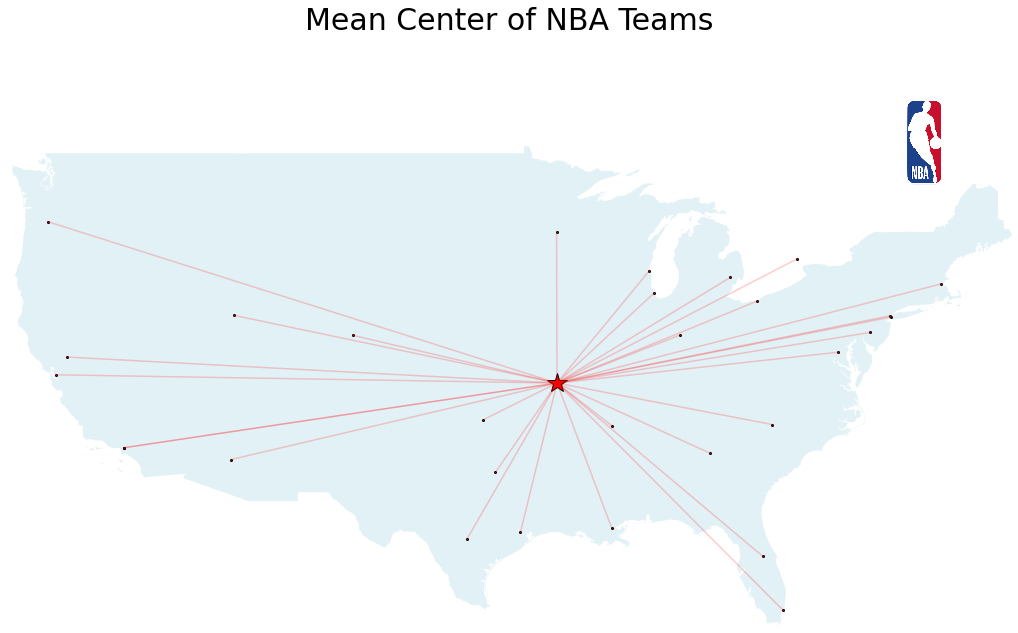

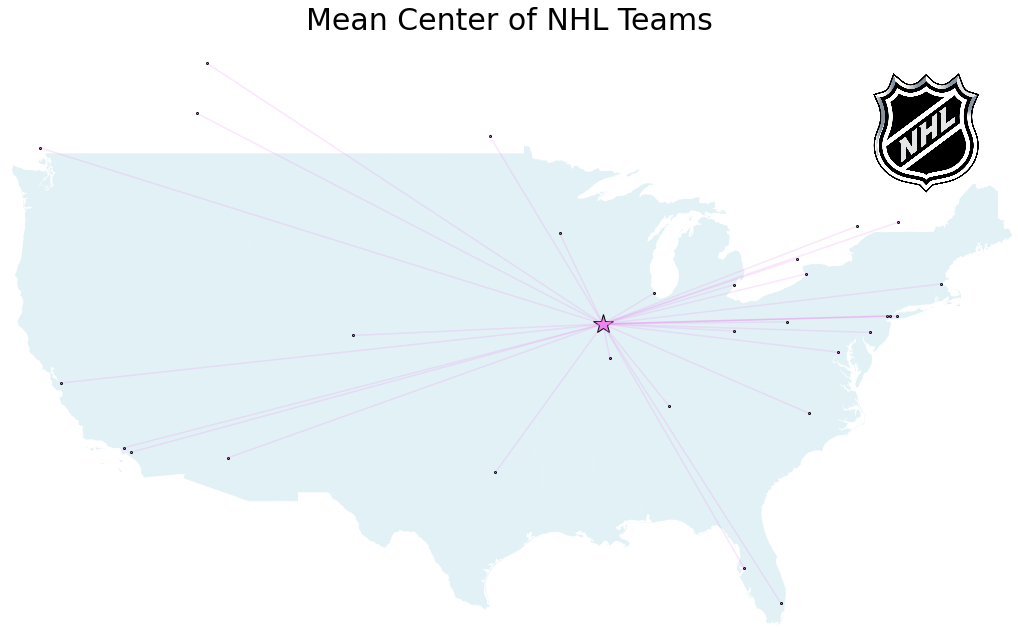

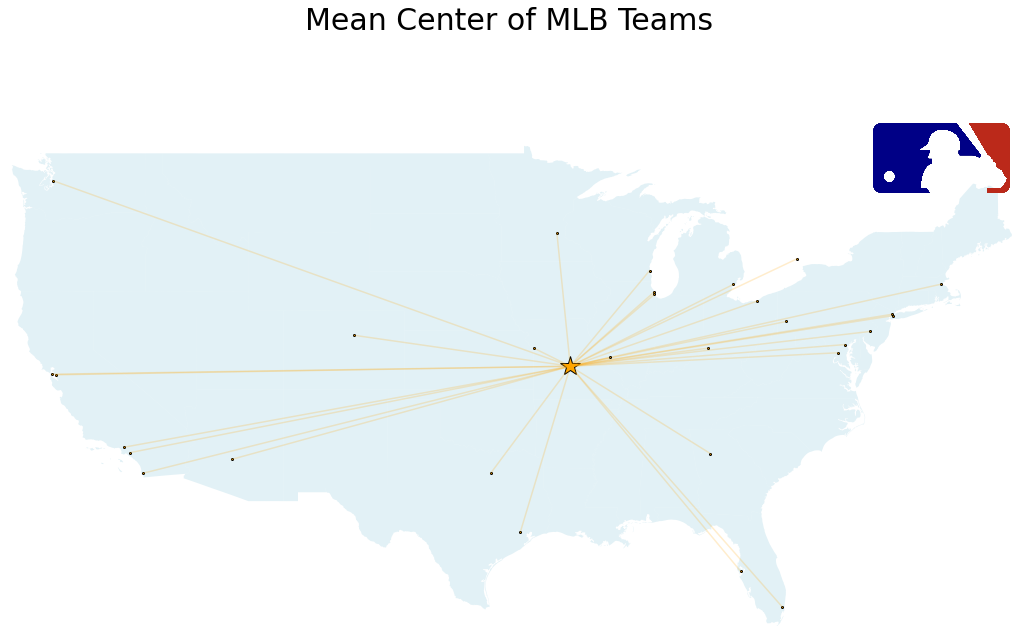

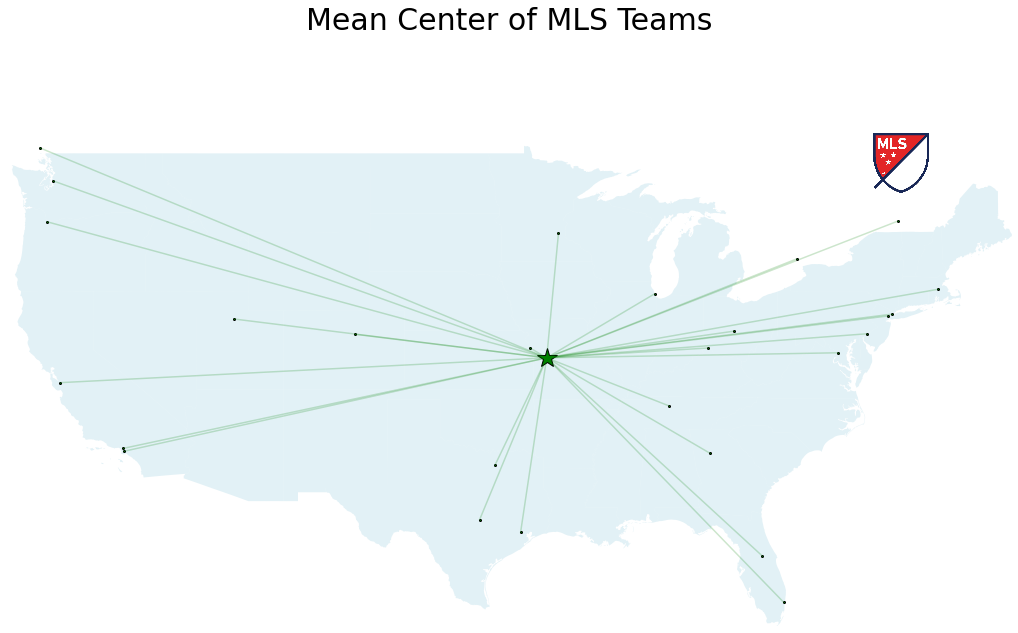

In [ ]:
# Loop
for league in majors:
  fig,ax = plt.subplots(figsize = (18,18))
  shp.plot(ax=ax, color='lightblue', alpha=0.35);
  plt.xlim(-125, -67);
  plt.ylim(25, 55);

  # Logo:
  png = majors[league][3]
  im = plt.imread(f'/content/{png}')
  imagebox = OffsetImage(im, zoom=.2, zorder=1)
  imagebox.image.axes = ax
  ab = AnnotationBbox(imagebox, (-75, 47),
                    xybox=(0, 0),
                    xycoords='data',
                    boxcoords="offset points",
                    box_alignment=(0.0,0),
                    pad=0,
                    frameon=False)
  ax.add_artist(ab)

  # League:
  df = majors[league][0]
  latcol, lngcol = majors[league][1], majors[league][2]
  mLNG = df[lngcol].sum()/len(df)
  mLAT = df[latcol].sum()/len(df)
  col = majors[league][4]

  # Plot:
  ax.plot(mLNG, mLAT, marker='*', markersize=20, c=col, markeredgecolor='black')
  for i in range(len(df)):
    team = df.iloc[i]
    ax.plot(team[lngcol], team[latcol], marker='o', markersize=2, c=col, alpha=1, markeredgecolor='black');
    ax.plot([team[lngcol],mLNG], [team[latcol],mLAT], c=col, alpha=0.2)

  ax.axis('off')
  ax.set_title(f'Mean Center of {league} Teams', fontsize=30);

## Weighted Mean Centers:

The average X and Y coordinate of the league, weighted by some other variable. In this case we will be weighting by:

*   of Championships won by franchise
*   Forbes Team Valuations



### Formula for weighted mean centers:
$X_W = \sum_{i = 1}^{n} w_i X_i / \sum_{i = 1}^{n} w_i$

In [ ]:
# Getting weights into dataframes:
nbaChamps = pd.read_html('https://en.wikipedia.org/wiki/List_of_NBA_champions')[2]
nhlChamps = pd.read_html('https://en.wikipedia.org/wiki/List_of_Stanley_Cup_champions')[4]
nflChamps = pd.read_html('https://en.wikipedia.org/wiki/List_of_Super_Bowl_champions#Super_Bowl_wins_by_team')[3]
mlbChamps = pd.read_html('https://en.wikipedia.org/wiki/List_of_World_Series_champions')[2]
mlsChamps = pd.read_html('https://en.wikipedia.org/wiki/List_of_MLS_Cup_finals')[2]

In [ ]:
# NBA merge:
nbaChamps['Teams'] = nbaChamps['Teams'].apply(lambda x : x.split('[')[0])
nbaChamps = nbaChamps.rename(columns={'Teams' : 'Team'})

for i in nbaChamps[nbaChamps['Win'] == '—']['Win'].index:
  nbaChamps.loc[i]['Win'] = 0
  
nba = nba.merge(nbaChamps, on='Team')
nba = nba.rename(columns={'Win':'Wins'})
nba['Wins'] = nba['Wins'].astype(int)

In [ ]:
# NHL merge:
nhlChamps['Team'] = nhlChamps['Team'].apply(lambda x : x.split('[')[0])
nhl = nhl.reset_index().rename(columns={'index' : 'Team'})
nhl = nhl.merge(nhlChamps, on='Team', how='outer')
nhl['Wins'] = nhl['Wins'].fillna(0)

# Vegas Golden Knights:
nhl.at[30, 'lat'] = 36.102778
nhl.at[30, 'long'] = -115.178333

In [ ]:
# NFL merge:

# Cleaning:
nflChamps['Team'] = nflChamps['Team'].apply(lambda x: x.split('[')[0])
nflChamps['Team'] = nflChamps['Team'].apply(lambda x: x[0:-1])
nflChamps['Team'] = nflChamps['Team'].apply(lambda x: x.split(' ')[-1])

# Matching:
nflChamps.at[3, 'Team'] = 'Forty-Niners'
nflChamps.at[4, 'Team'] = 'Packers'
nflChamps.at[7, 'Team'] = 'Redskins'
nflChamps.at[8, 'Team'] = 'Raiders'
nflChamps.at[10, 'Team'] = 'Colts'
nflChamps.at[11, 'Team'] = 'Chiefs'
nflChamps.at[20, 'Team'] = 'Vikings'
nflChamps.at[9, 'Team'] = 'Raiders'

nfl = nfl.merge(nflChamps, on='Team')

In [ ]:
# MLB merge:
mlb = mlb.rename(columns={'team':'Team'})
mlbChamps['Team'] = mlbChamps['Team'].apply(lambda x : x.split('/ ')[-1])
# matching:
mlbChamps.at[19, 'Team'] = 'Florida Marlins'
mlbChamps.at[22, 'Team'] = 'Anaheim Angels'
mlbChamps.at[25, 'Team'] = 'Tampa Bay Devil Rays'
mlb = mlb.merge(mlbChamps, on='Team')

In [ ]:
# MLS merge:
mls = mls.rename(columns={'team':'Team'})
mls = mls.merge(mlsChamps, on='Team', how='outer')

In [ ]:
# Dict of Major Leagues and their coordinate columns, logo pngs, colors
majors = {
    'NFL' : (nfl, 'latitude', 'longitude', 'nfl.png', 'blue'),
    'NBA' : (nba, 'latitude', 'longitude', 'nba.png', 'red'),
    'NHL' : (nhl, 'lat', 'long', 'nhl.png', 'violet'),
    'MLB' : (mlb, 'lat', 'lng', 'mlb.png', 'orange'),
    'MLS' : (mls, 'latitude', 'longitude', 'mls.png', 'green')}

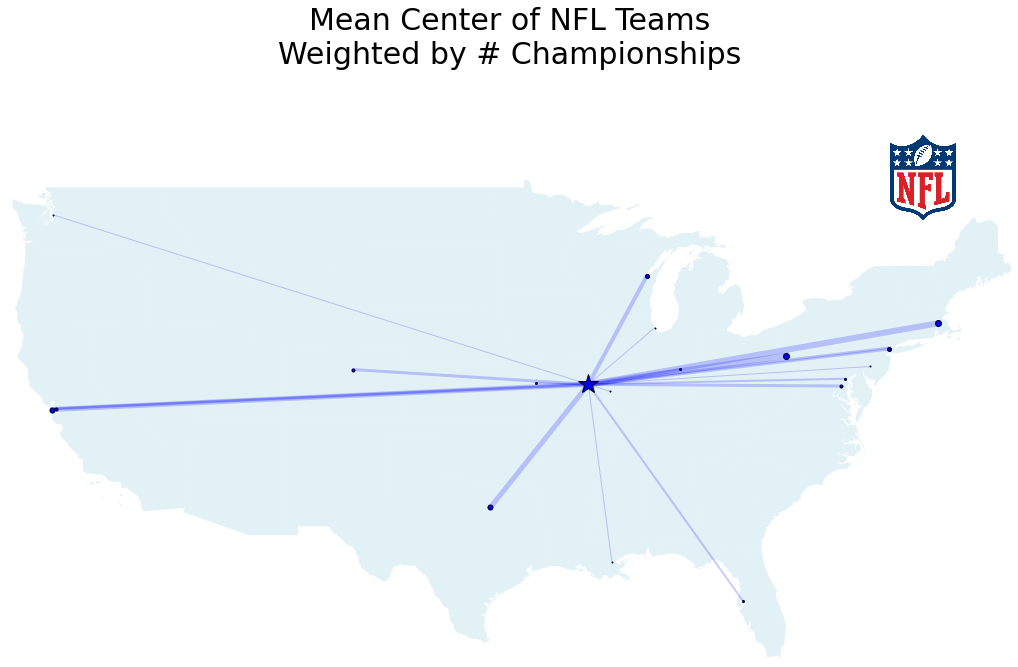

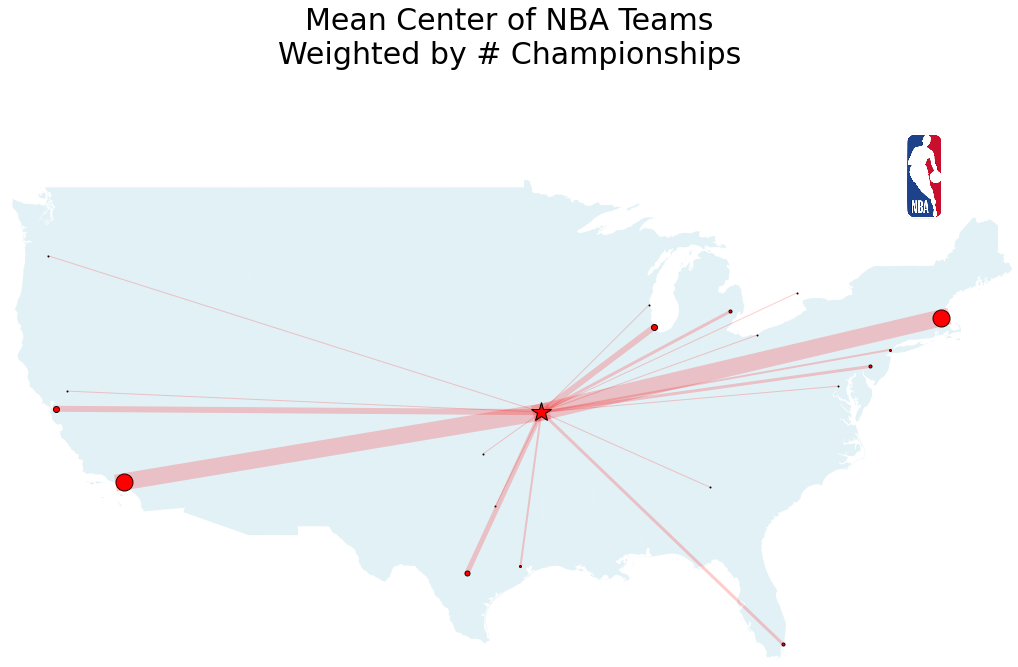

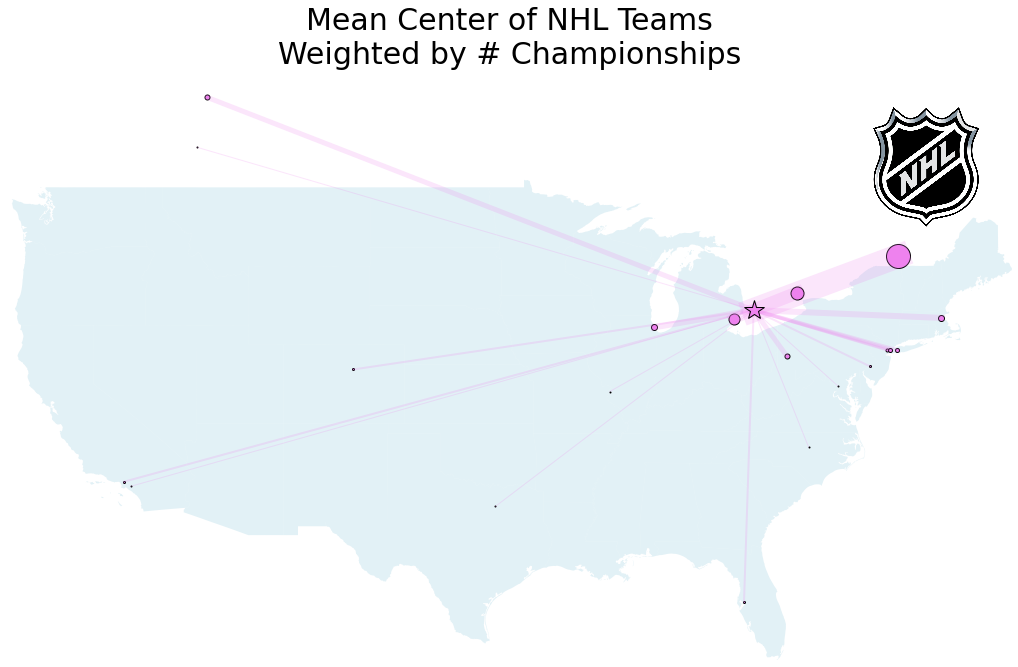

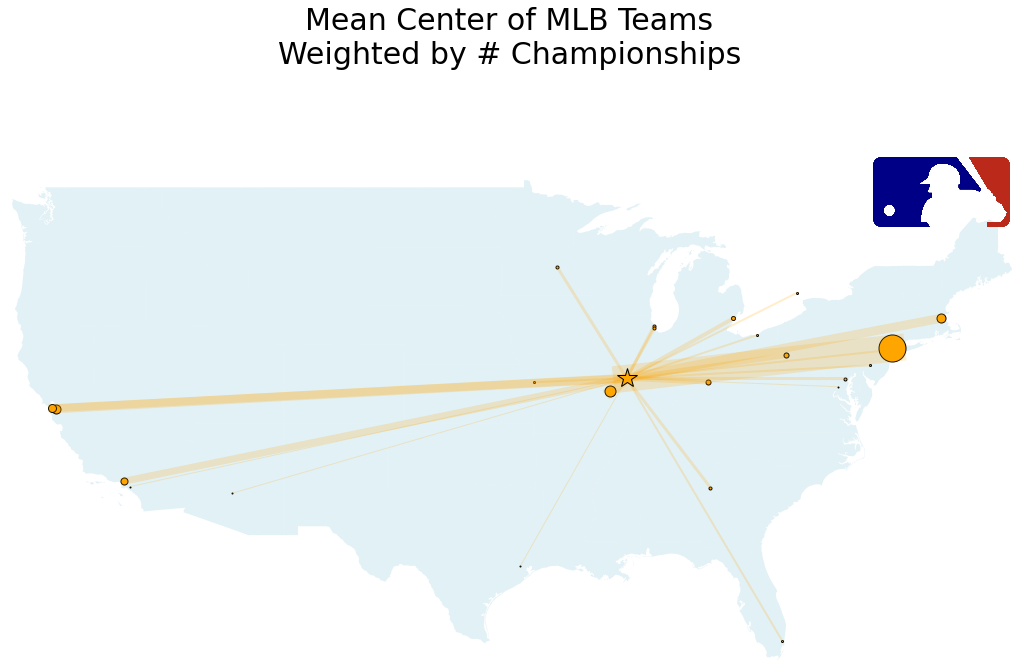

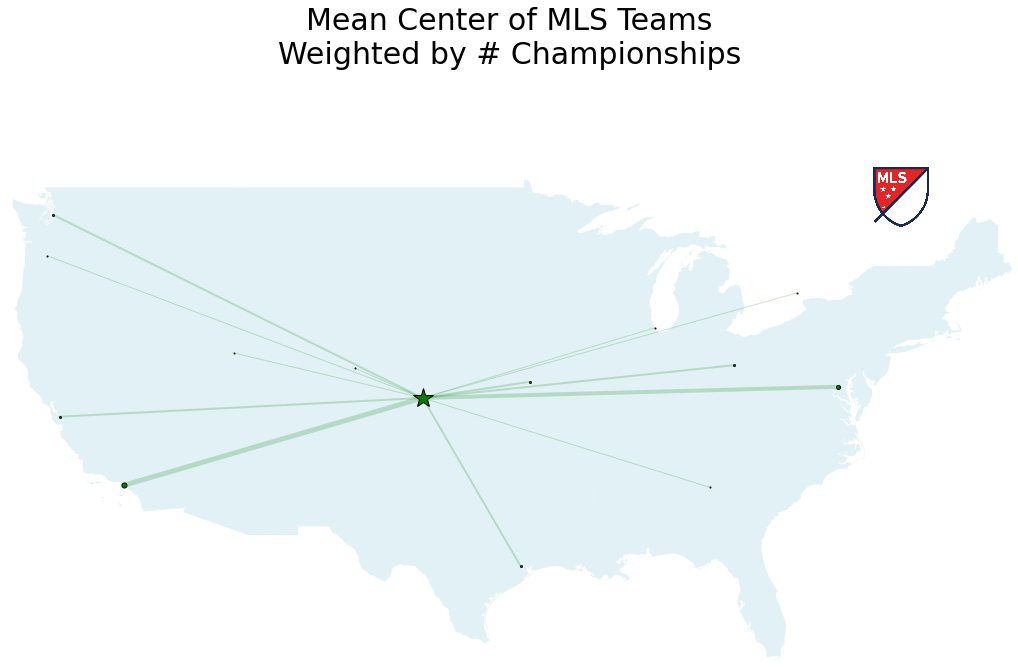

In [ ]:
# Loop:
for league in majors:
  fig,ax = plt.subplots(figsize = (18,18))
  shp.plot(ax=ax, color='lightblue', alpha=0.35);
  plt.xlim(-125, -67);
  plt.ylim(25, 55);

  # Logo:
  png = majors[league][3]
  im = plt.imread(f'/content/{png}')
  imagebox = OffsetImage(im, zoom=.2, zorder=1)
  imagebox.image.axes = ax
  ab = AnnotationBbox(imagebox, (-75, 47),
                    xybox=(0, 0),
                    xycoords='data',
                    boxcoords="offset points",
                    box_alignment=(0.0,0),
                    pad=0,
                    frameon=False)
  ax.add_artist(ab)

  # League:
  df = majors[league][0]
  latcol, lngcol = majors[league][1], majors[league][2]

  df['wla'] = df[latcol]*df['Wins'] # weighted latitudes
  df['wlo'] = df[lngcol]*df['Wins'] # weighted longitudes
  totalwins = df['Wins'].sum()
  WchampLat, WchampLng = df['wla'].sum()/totalwins, df['wlo'].sum()/totalwins

  col = majors[league][4]
 
  # Plot:
  for i in range(len(df)):
    team = df.iloc[i]
    ax.plot(team[lngcol], team[latcol], marker='o', markersize=team['Wins'], c=col, alpha=1, markeredgecolor='black');
    ax.plot([team[lngcol],WchampLng], [team[latcol],WchampLat], c=col, lw=team['Wins'], alpha=0.2)

  ax.plot(WchampLng, WchampLat, marker='*', markersize=20, c=col, markeredgecolor='black')

  ax.axis('off');
  ax.set_title(f'Mean Center of {league} Teams\nWeighted by # Championships', fontsize=30);

# Forbes Team Valuations:

In [ ]:
# Parse Dependencies
import requests
from bs4 import BeautifulSoup

In [ ]:
# NHL:
nhlforbes = 'https://www.forbes.com/sites/mikeozanian/2020/12/09/nhl-team-values-2020-hockeys-first-decline-in-two-decades/?sh=35ad9c7c70dd'
r = requests.get(nhlforbes)
soup = BeautifulSoup(r.text, 'html.parser')
h2s = soup.find_all('h2')
nhlvals =  pd.DataFrame(columns=['Team', 'Value'])

# Construct df from h2 tags
for team in h2s:
  teamname = team.text
  teamval = team.findNext('p').text
  newrow = pd.DataFrame({'Team' : teamname,
          'Value' : teamval}, index=[0])
  nhlvals = nhlvals.append(newrow)

# Cleaning:
nhlvals = nhlvals.reset_index().drop(0).drop(columns='index')
nhlvals = nhlvals[nhlvals['Team'] != '']
nhlvals['Team'] = nhlvals['Team'].apply(lambda x : x.split('. ')[-1])
nhlvals['Value'] = nhlvals['Value'].apply(lambda x : x.replace(' million',''))
nhlvals['Value'] = nhlvals['Value'].apply(lambda x : x.split('$')[-1])
nhlBillions = nhlvals['Value'][0:5].apply(lambda x : x.replace(' billion',''))
nhlMillions = nhlvals['Value'][5:-1].astype(float).apply(lambda x : x/1000)
nhlvals['Value'] = nhlBillions.append(nhlMillions)

# Matching:
nhlvals.at[32, 'Value'] = .285
nhlvals.at[32, 'Team'] = 'Phoenix Coyotes'
nhlvals.at[19, 'Team'] = 'St. Louis Blues'

nhlvals['Value'] = nhlvals['Value'].astype(float)
nhl = nhl.merge(nhlvals, on='Team', how='outer')

In [ ]:
# NFL: (uploaded csv)
nflvals = pd.read_csv('/content/NFLvals2020.csv')

# Cleaning:
nflvals['Value'] = nflvals['Value'].apply(lambda x : x.replace(' B','').replace('$',''))
nflvals['Value'] = nflvals['Value'].astype(float)
nflvals['Team'] = nflvals['Team'].apply(lambda x : x.split(' ')[-1])

# Matching:
nflvals.at[7, 'Team'] = 'Redskins'
nflvals.at[4, 'Team'] = 'Forty-Niners'

nfl = nfl.merge(nflvals, on='Team', how='outer')

In [ ]:
# MLB: (uploaded csv)
mlbvals = pd.read_csv('/content/MLBvals2021.csv')
mlbvals['Value'] = mlbvals['Value'].apply(lambda x : x.replace('$', '').replace(' B', ''))

# Matching:
mlbvals.at[29, 'Value'] = 0.99
mlbvals.at[6, 'Team'] = 'St. Louis Cardinals'
mlbvals.at[8, 'Team'] = 'Anaheim Angels'
mlbvals.at[28, 'Team'] = 'Tampa Bay Devil Rays'
mlbvals.at[29, 'Team'] = 'Florida Marlins'

# Cleaning
mlbvals['Value'] = mlbvals['Value'].astype(float)
mlb = mlb.rename(columns={'team':'Team'})

mlb = mlbvals.merge(mlb, on='Team', how='outer')

In [ ]:
# NBA:
nbaforbes = 'https://www.forbes.com/sites/kurtbadenhausen/2021/02/10/nba-team-values-2021-knicks-keep-top-spot-at-5-billion-warriors-bump-lakers-for-second-place/?sh=17202057645b'
r = requests.get(nbaforbes)
soup = BeautifulSoup(r.text, 'html.parser')
h3s = soup.find_all('h3')
nbavals =  pd.DataFrame(columns=['Team', 'Value'])

# Construct df from h3 tags:
for team in h3s:
  teamname = team.text
  teamval = team.findNext('h4').text
  newrow = pd.DataFrame({'Team' : teamname,
          'Value' : teamval}, index=[0])
  nbavals = nbavals.append(newrow)

# Cleaning:
nbavals = nbavals[nbavals.Team != '']
nbavals['Team'] = nbavals['Team'].apply(lambda x : x.split('. ')[-1])
nbavals['Team'] = nbavals['Team'].apply(lambda x : x.strip())
nbavals['Value'] = nbavals['Value'].apply(lambda x : x.replace(' billion', ''))
nbavals['Value'] = nbavals['Value'].apply(lambda x : x.split('$')[-1])
nbavals['Value'] = nbavals['Value'].astype(float)

nba = nba.merge(nbavals, on='Team')

In [ ]:
# MLS: (uploaded csv)
mlsvals = pd.read_csv('/content/MLSvals2019.csv')

# Matching:
mlsvals.at[0, 'Team'] = 'Atlanta United FC'
mlsvals.at[2, 'Team'] = 'Los Angeles FC'
mlsvals.at[3, 'Team'] = 'Seattle Sounders FC'
mlsvals.at[7, 'Team'] = 'Chicago Fire FC'
mlsvals.at[8, 'Team'] = 'D.C. United'
mlsvals.at[10, 'Team'] = 'Minnesota United FC'
mlsvals.at[14, 'Team'] = 'Houston Dynamo FC'
mlsvals.at[20, 'Team'] = 'Vancouver Whitecaps FC'
mlsvals.at[21, 'Team'] = 'CF Montréal'
mlsvals.at[22, 'Team'] = 'Columbus Crew SC'

mls = mls.merge(mlsvals, how='outer')

# Cleaning:
mls = mls.rename(columns={'Value ($M)':'Value'})
mls['Value'] = mls['Value']/1000 # value in billions

In [ ]:
# Dict of Major Leagues and their coordinate columns, logo pngs, colors
majors = {
    'NFL' : (nfl, 'latitude', 'longitude', 'nfl.png', 'blue'),
    'NBA' : (nba, 'latitude', 'longitude', 'nba.png', 'red'),
    'NHL' : (nhl, 'lat', 'long', 'nhl.png', 'violet'),
    'MLB' : (mlb, 'lat', 'lng', 'mlb.png', 'orange'),
    'MLS' : (mls, 'latitude', 'longitude', 'mls.png', 'green')}

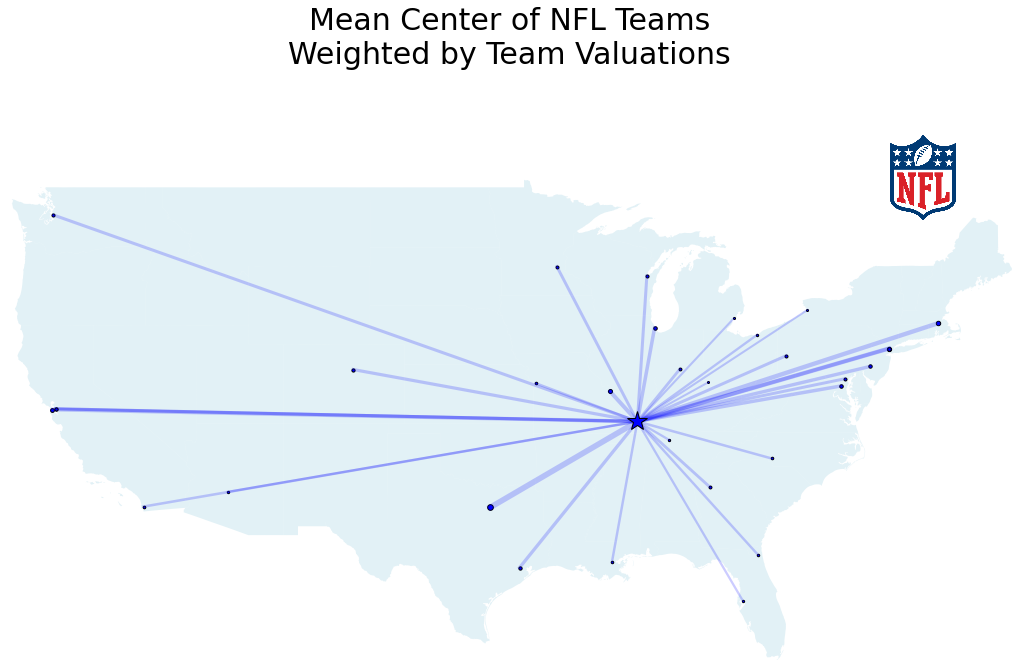

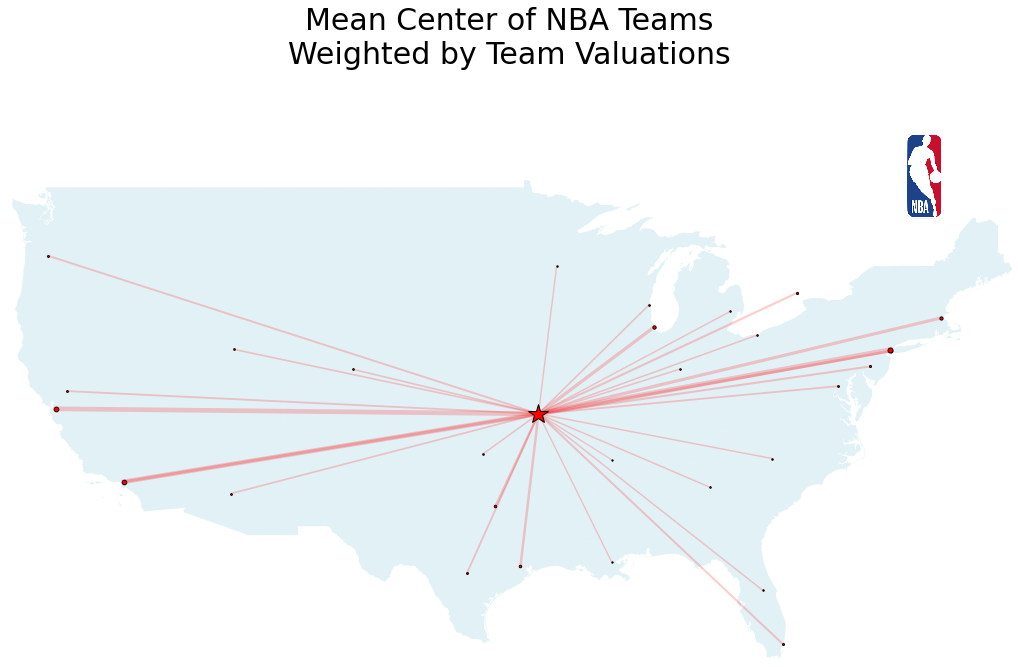

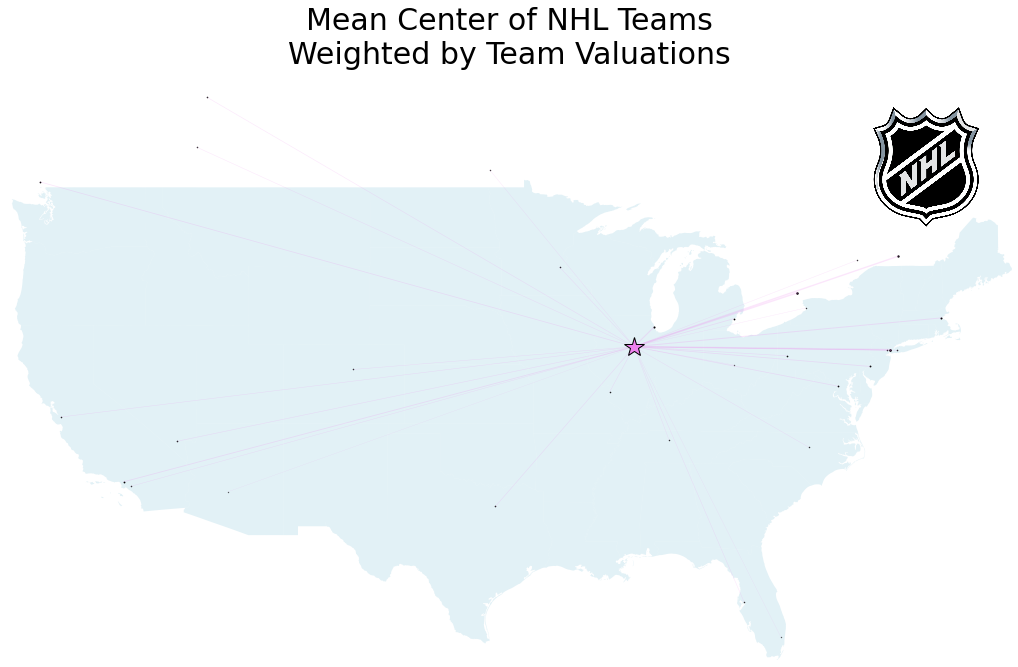

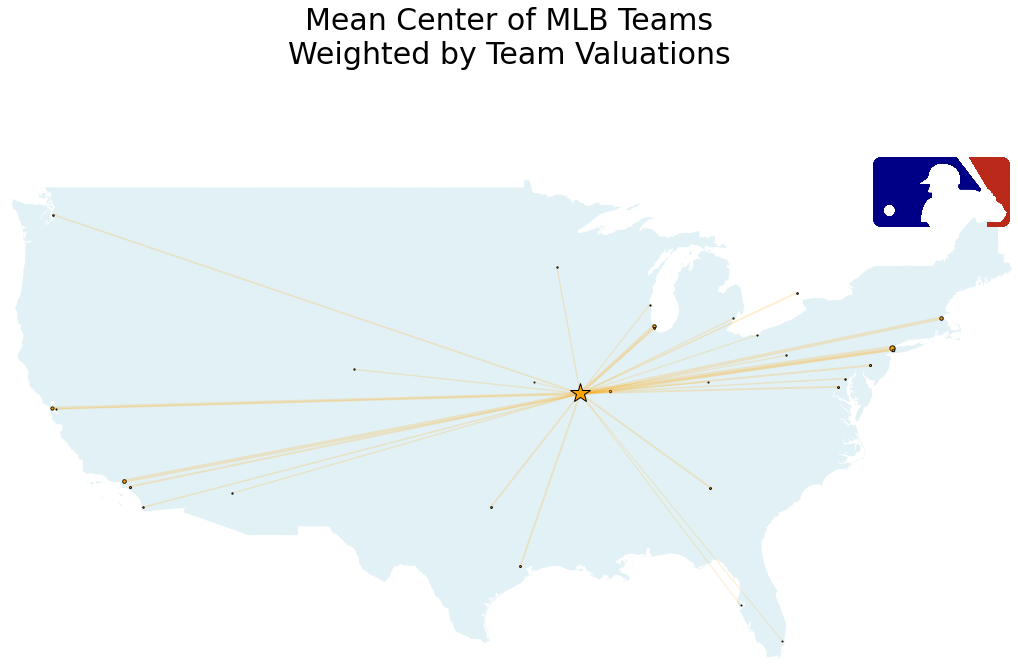

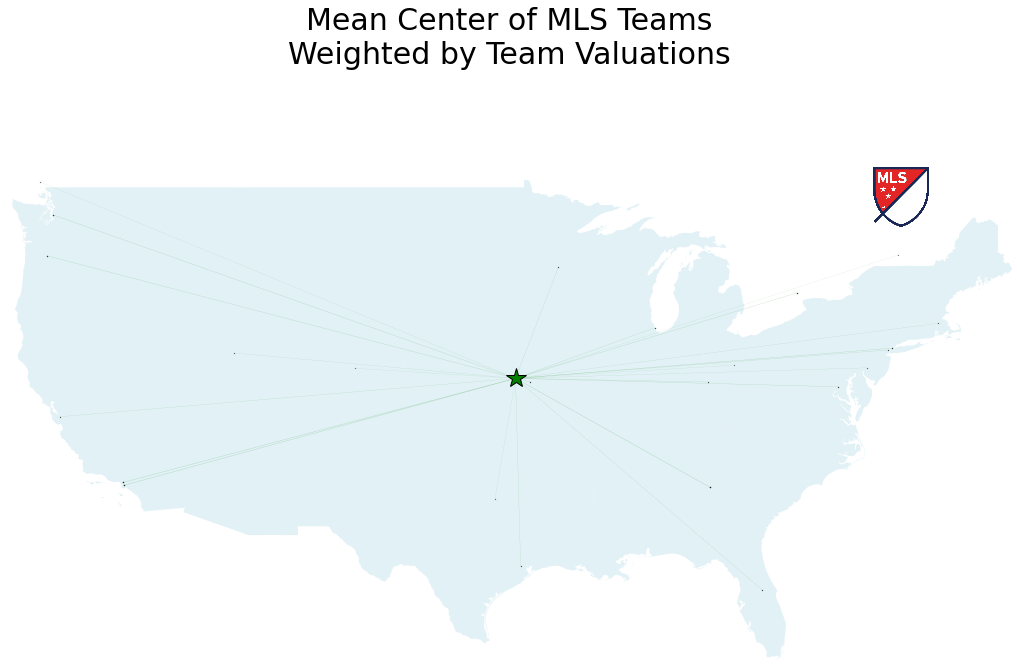

In [ ]:
# Loop:
for league in majors:
  fig,ax = plt.subplots(figsize = (18,18))
  shp.plot(ax=ax, color='lightblue', alpha=0.35);
  plt.xlim(-125, -67);
  plt.ylim(25, 55);

  # Logo:
  png = majors[league][3]
  im = plt.imread(f'/content/{png}')
  imagebox = OffsetImage(im, zoom=.2, zorder=1)
  imagebox.image.axes = ax
  ab = AnnotationBbox(imagebox, (-75, 47),
                    xybox=(0, 0),
                    xycoords='data',
                    boxcoords="offset points",
                    box_alignment=(0.0,0),
                    pad=0,
                    frameon=False)
  ax.add_artist(ab)

  # League:
  df = majors[league][0]
  latcol, lngcol = majors[league][1], majors[league][2]

  df['vla'] = df[latcol]*df['Value'] # weighted latitudes
  df['vlo'] = df[lngcol]*df['Value'] # weighted longitudes
  totalval = df['Value'].sum()
  WvalLat, WvalLng = df['vla'].sum()/totalval, df['vlo'].sum()/totalval

  col = majors[league][4]
 
  # Plot:
  for i in range(len(df)):
    team = df.iloc[i]
    ax.plot(team[lngcol], team[latcol], marker='o', markersize=team['Value'], c=col, alpha=1, markeredgecolor='black');
    ax.plot([team[lngcol],WvalLng], [team[latcol],WvalLat], c=col, lw=team['Value'], alpha=0.2)
  ax.plot(WvalLng, WvalLat, marker='*', markersize=20, c=col, markeredgecolor='black')

  ax.axis('off');
  ax.set_title(f'Mean Center of {league} Teams\nWeighted by Team Valuations', fontsize=30);